# Projet numérique : lignes de niveau

Auteurs : Quentin GUITET, Aymeric PLESSIER

Date de dernière modification : vendredi 1 novembre 2019

Notre travail a pour but final d'être capable d'afficher les lignes de niveau d'une fonction réelle f de deux variables réelles, supposée continûement différentiable.

In [2]:
#prerequis : importer matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy as np

# Méthode de la dichotomie

Si $f$ est continue (c'est a fortiori le cas si f est continuement différentiable), alors la composition de f et de tout arc paramétré est continue.
En particulier, définissons l'arc paramétré $\gamma: t\in[0,1] \mapsto (0,t)\in\mathbb{R}²$.
La fonction $g=f\circ g$ est continue.

Soit $c$ un réel. En supposant que $f(0,0)-c$ et $f(0,1)-c$ sont de signes opposés, par le théorème des valeurs intermédiaires appliqué à g, il existe alors $t\in [0,1]$ tel que $f(0,t)=c$.

Cela prouve théoriquement l'existence d'un tel c. On se propose de coder ici une fonction $find\_seed$ qui utilise une méthode de dichotomie pour approcher ce réel, à partir d'une fonction telle que $g$.

In [3]:
def find_seed(g, a=0, b=1, c=0, eps=2**-26) :
    """Approche par dichotomie un antécedent a c par la fonction continue g,
    en démarrant la dichotomie aux points a et b. S'arrête a une précision eps (longueur de l'intervalle de fluctuation).
    Leve une exception si la condition de base de la dichotomie n'est pas respectee."""
    
    if b<a : a,b = b,a
        
    if g(a)>g(b) :
        h = lambda x : c-g(x)
    else :
        h = lambda x : g(x)-c
    #on se ramène à une fonction "presque croissante" à annuler

    assert h(a)*h(b)<=0
    
    for i in range(20) : #si au bout de 20 tours on n'est toujours pas sous eps, on arrête quand même
        m = (b+a)/2
        if h(m)<0 : a = m
        else : b = m
        if b-a<eps : break
    
    return (b+a)/2

Remarque : on a pris quelques libertés par rapport au sujet, en rajoutant des paramétres a et b afin d'avoir une fonction plus génerale

Dès lors, on peut imaginer une méthode de tracé de contour n'utilisant pas l'hypothèse de fonction continûement différentiable : on trace pas à pas en utilisant la dichotomie, en utilisant comme arc paramétré non pas un segment mais un demi-cercle de rayon delta. Ainsi, à chaque étape, on trouve un nouveau point de la ligne de niveau.
Cela demande toutefois de connaître la direction du segment de contour précédemment tracé pour ne pas revenir sur nos pas. Pour cela, on se donne à chaque étape un angle theta_0 et on cherche sur le demi-cercle "dans le sens de cet angle". Pour initialiser la ligne de niveau, on commence sur le bord gauche (avec une dichotomie classique), on a donc un theta_0 = 0. Ensuite, c'est l'angle du précédent pas tracé qui est utilisé.
La fonction $pas$ réalise chaque pas en utilisant la fonction de dichotomie $find\_seed$, et la fonction $simple\_contour$ correspond à celle demandée par l'énoncé (on a rajouté un paramètre facultatif ad-hoc $ext$ pour le fonctionnement de l'algorithme, ainsi qu'une fonction $extension$ par commodité, voir description des fonctions).

In [4]:
def extension(f,x0=0,y0=0,x1=1,y1=1) :
    """Etend une fonction f au-delà de son domaine de définition initial."""
    def h(x,y) :
        if x<x0 :
            if y<y0 : return f(x0,y0)
            elif y>y1 : return f(x0,y1)
            else : return f(x0,y)
        elif x>x1 :
            if y<y0 : return f(x1,y0)
            elif y>y1 : return f(x1,y1)
            else : return f(x1,y)
        else :
            if y<y0 : return f(x,y0)
            elif y>y1 : return f(x,y1)
            else : return f(x,y)
    return h

def pas(f, c=0.0, delta=0.05, mvmt=0,x0=0,y0=0) :
    """Réalise un pas par dichotomie
    mvmt : dernier mouvement réalisé (retour de cette même fonction)
              OU BIEN theta_0 directement si départ (dans ce cas préciser le point de depart avec x0 et y0)
    f doit être définie un peu en dehors de [0,1]x[0,1]
    Sortie : nouveau point sous la forme (x,y)"""
    
    if isinstance(mvmt,int) or isinstance(mvmt, float) :
        theta_0 = mvmt
    else :
        deltax = mvmt[0][1]-mvmt[0][0]
        deltay = mvmt[1][1]-mvmt[1][0]
        x0 = mvmt[0][1]
        y0 = mvmt[1][1]
        theta_0 = np.arccos(deltax/delta)*(1-2*(deltay<0)) #permet de trouver l'angle du vecteur mvmt, sachant que sqrt(x²+y²)=~delta (1-2*etc)=le signe de deltay
        
    def gamma(theta) :
        thet=theta+theta_0
        return (x0+delta*np.cos(thet), y0+delta*np.sin(thet))
    
    g = lambda theta : f(*gamma(theta))
    
    try :
        theta = find_seed(g, -np.pi/2, np.pi/2, c)
    except : #si la dichotomie échoue
        raise Exception("Arrêt de la ligne de niveau ou problème de seuils")
    
    thet = theta+theta_0
    
    return (x0+delta*np.cos(thet), y0+delta*np.sin(thet))


def simple_contour(f,c=0,delta=0.05,depart="gauche",ext = True) :
    """Trace une ligne de niveau entiére à partir d'un antécedent de c sur le côté gauche du carré de côté 1
    renvoie deux listes de coordonnées (les x et les y).
    Ne marche pas si la dichotomie de départ est impossible.
    départ est le bord sur lequel est faite la dichotomie
    Si f n'est pas définie en dehors de [0,1],
    elle est étendue légerement autour afin de simplifier le fonctionnement de l'algorithme
    (les dichotomies peuvent dépasser des bords, cela évite d'avoir à gérer ces cas).
    Pour désactiver cette extension automatique (dans le cas ou f est bien definie sur RxR), on peut initialiser
    le paramétre ext à False (True par défaut, pour éviter les bugs)"""

    if ext : h = extension(f)
    else : h = f

    if depart=="gauche" :
        theta0=0
        g = lambda y : f(0,y)
        x0 = 0
        try : y0 = find_seed(g,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="droite" :
        theta0=np.pi
        g = lambda y : f(1,y)
        x0 = 1
        try : y0 = find_seed(g,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="bas" :
        theta0=np.pi/2
        g = lambda x : f(x,0)
        y0=0
        try : x0 = find_seed(g,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="haut" :
        theta0 = -np.pi/2
        y0=1
        g = lambda x : f(x,1)
        try : x0 = find_seed(g,c=c)
        except Exception as Exc :
            return [],[]
    else : raise ValueError("départ doit être haut, bas, droite ou gauche")

    try :
        x1,y1 = pas(h,c,delta=delta,mvmt=theta0,x0=x0,y0=y0)
    except Exception as Exc:
        return [],[]
    

    X = [x0,x1]
    Y = [y0,y1]
    
    while 0<=x1<=1 and 0<=y1<=1 :
        try :
            x1,y1 = pas(h,c,delta=delta,mvmt=([X[-2],X[-1]],[Y[-2],Y[-1]]))
            X.append(x1)
            Y.append(y1)
        except Exception as exc:
            break
            
    return X, Y


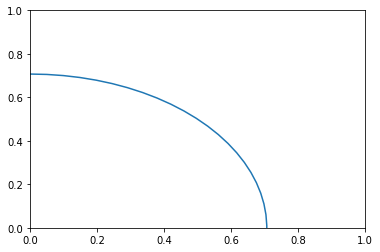

In [5]:
#résultat

def f(x,y) :
    return x*x+y*y

plt.axis([0, 1, 0, 1])
X, Y = simple_contour(f,c=0.5)

plt.plot(X,Y)

plt.show()

Conclusion :
 - La méthode marche efficacement, on peut même prendre un pas $delta$ relativement grand et obtenir des résultats très satisfaisants en règle générale (ce qui rend la méthode efficace).
 - Pour qu'elle marche, il faut cependant que la fonction (éventuellement corrigée de la valeur c) soit positive à une extrêmité du demi-cercle et négative à l'autre. Il faut aussi que la ligne de niveau ne change pas trop "brutalement" de direction par rapport au pas delta. En général, ces deux contraintes se résolvent en prenant $delta$ assez petit. Toutefois, concernant le premier problème, cela exclue les lignes de niveau extrêmes (par exemple, la méthode ne fonctionne pas sur $f: (x,y)\in\mathbb{R}² \mapsto x²\in\mathbb{R}$ pour la ligne de niveau associée à la valeur 0), qui représentent la plupart des cas pathologiques pour beaucoup de méthodes envisagées par ailleurs.
 - La gestion des lignes de niveau "en 8" (comme on peut en trouver près des points-cols) est assez aléatoire
 - En notant $l$ la longueur de la ligne de niveau, $eps$ la précision utilisée pour la dichotomie, $delta$ la distance entre deux points successifs, en ne comptant que les appels de la fonction, la complexité grosso-modo proportionnelle à $log(eps)*l/delta$

Remarque : nous avions aussi pensé, pour chaque pas, à calculer le gradient en le point, et à avancer perpendiculairement d'un segment de longeur $delta$. Toutefois, cette méthode à plusieurs défauts majeurs par rapport à la précédente :
 - Cela suppose une fonction différentiable (alors qu'une fonction continue suffit pour la première méthode).
 - Si le gradient est nul, la méthode ne marche pas. On exclue dès lors les fonctions du type $f: (x,y)\in\mathbb{R}² \mapsto x^3\in\mathbb{R}$, pour la ligne de niveau 0 : on a bien un gradient nul en ces points. Toutefois, cela n'empêche pas le premier algorithme de fonctionner.
 - On risque d'avoir une déviation progressive à chaque pas par rapport à la ligne de niveau. Ce dernier problème pourrait être résolu en faisant à nouveau une dichotomie sur un petit segment autour du point d'arrivée, mais on a alors les défauts de la première méthode ; ceci n'aurait donc pas d'intérêt.

Maintenant, il s'agît d'utiliser cette "brique de base" pour afficher les lignes de niveau sur n'importe quel pavé à l'aide d'un quadrillage.
La méthode est la suivante : on prend notre fonction f (qu'on étend éventuellement en dehors de l'intervalle par commodité, si besoin), et on se donne un quadrillage sous la forme demandée par le sujet (xc et yc). Ensuite, pour chaque petit carré, exécute $simple\_contour$ en tentant de partir des 4 bords du carré. Si aucune graine n'est trouvée, il on passe au carré suivant. Si une graine est trouvée, on trace le fragment de ligne de niveau à partir de la graine et on arrête de chercher d'éventuelles autres graines sur les autres bords (pour éviter de tracer les lignes de niveau en double ; on suppose alors que l'utilisateur a mis un quadrillage assez fin pour éviter d'avoir plusieurs lignes de niveau passant dans le même carré).
Remarques :
 - Pour avoir de la modularité (et ainsi d'utiliser la même fonction contour quelle que soit la fonction $contour\_simple$), des calculs assez lourds sont nécessaires. Des adaptations mineures sur la fonction $contour\_simple$ pourraient être faites. Il au contraire possible d'être encore plus modulaire, et de n'avoir une fonction $contour\_simple$ qui commence qu'à partir du bord gauche (comme demandé dans l'énoncé), en reprenant une nouvelle fonction (voir ci dessous) du type $h = lambda x,y : f(xc[i]+x*deltax, yc[j]+y*deltay)$ pour chaque bord à tester en permutant éventuellement x et y, et en remplaçant éventuellement $x$ et $y$ par $(1-x)$ et $(1-y)$.
 - Etant donné la méthode employée, il est possible qu'il y ait quelques chevauchements des lignes sur les carrés.
 - Afin de pouvoir *plotter* proprement les points, et d'éviter les raccords malencontreux, contrairement à ce qui était demandé dans l'énoncé, nous renvoyons non pas une unique liste de coordonnées X et une unique liste de coordonnées Y, mais deux listes de listes de points à relier entre deux.

In [6]:
def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.05, ext = True) :
    """Renvoie les coordonnées d'une ligne de niveau pour une fonction f,
    l'algorithme utilise la fonction "contour_simple" sur chaque petit rectangle donné.
    Renvoie des listes de listes des coordonnées X et Y des points à plotter
    (pour éviter les raccords malencontreux)"""

    if ext :
        f = extension(f, x0=xc[0], y0=yc[0], x1=xc[-1], y1=yc[-1])

    n = len(xc)-1
    m = len(yc)-1

    mat = np.ones((n,m,2))*np.nan

    X = [] # attention, X contient plusieurs listes de points, utile s'il y a plusieurs lignes de niveau
    Y = [] # idem (pour plotter correctement)

    for i in range(len(xc)-1) : #on parcourt tous les carrés, jusqu'à trouver un point d'entrée
        for j in range(len(yc)-1) : #on se contente d'un point par carré pour éviter les problèmes, on considère que les autres cas necessiteraient des carrés plus petits
            deltax = xc[i+1]-xc[i]
            deltay = yc[j+1]-yc[j]

            #on va successivement tenter les différents bords, en adaptant la fonction f pour réutiliser la fonction simple_contour
            #(il y aurait probablement une méthode un peu plus optimisée mais moins pratique et modulaire)

            h = lambda x,y : f(xc[i]+x*deltax, yc[j]+y*deltay)
            XX, YY = simple_contour(h,c,delta=delta,depart="gauche",ext=False)
            if XX!=[] :
                X.append([xc[i]+x*deltax for x in XX])
                Y.append([yc[j]+y*deltay for y in YY])
                continue
            XX,YY = simple_contour(h,c,delta=delta,depart="bas",ext=False)
            if XX!=[] :
                X.append([xc[i]+x*deltax for x in XX])
                Y.append([yc[j]+y*deltay for y in YY])
                continue
            XX, YY = simple_contour(h,c,delta=delta,depart="haut",ext=False)
            if XX!=[] :
                X.append([xc[i]+x*deltax for x in XX])
                Y.append([yc[j]+y*deltay for y in YY])
                continue
            XX,YY = simple_contour(h,c,delta=delta,depart="droite",ext=False)
            if XX!=[] :
                X.append([xc[i]+x*deltax for x in XX])
                Y.append([yc[j]+y*deltay for y in YY])
                continue
    return X,Y

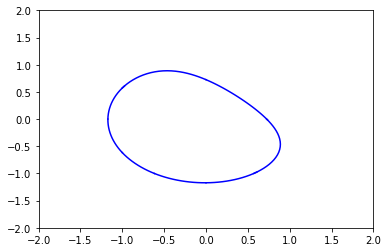

In [7]:
def f(x,y) :
    return 2*(np.exp(-x*x-y*y)-np.exp(-(x-1)**2-(y-1)**2))

plt.axis([-2, 2, -2, 2])
X, Y = contour(f,c=0.5,xc=[-2,-1,0,1,-2], yc=[-2,-1,0,1,2],ext=False)

for XX, YY in zip(X,Y) :
    plt.plot(XX,YY,color="blue")

plt.show()

# Méthode du gradient

### Principe

On sait que le vecteur gradient $\overrightarrow{\nabla f}$ est perpendiculaire à tout point de la ligne de niveau, on détermine donc simplement le vecteur perpendiculaire $\overrightarrow{U}$ au gradient allant dans le sens qui convient et de norme $\delta$

On a donc le schéma itératif suivant :
$$
\left \{
\begin{array}{r r}
      x_{k+1}  & = & x_k + U_{x_k} \\
      y_{k+1}  & = & y_k + U_{y_k}
\end{array}
\right  .
$$
Avec les quantités suivantes $$\overrightarrow{\nabla f}(x_k,y_k) = \begin{pmatrix} G_{x_k} \\ G_{y_k}\end{pmatrix}$$
$$\overrightarrow{V} = \begin{pmatrix} G_{y_k} \\ -G_{x_k}\end{pmatrix}$$  $$\overrightarrow{U} = \delta \frac{\overrightarrow{V}}{||\overrightarrow{V}||}$$

### Programme

In [19]:
import matplotlib.pyplot as plt
import autograd
import math
from autograd import numpy as np

In [20]:
### Définition de la fonction f

def f(x, y):
    """Définit la fonction dont on veut déterminer les lignes de niveaux"""
    return x**5 + y**2 + np.sin(x*y)

### Calcul de la fonction gradient à partir de autograd

def gradient(f):
    """Renvoie les dérivées partielles de f fonction de deux variables"""
    g = autograd.grad
    return g(f, 0), g(f, 1)

### Recherche de l'amorce

def find_seed(g, a=0, b=1, c=0, eps=2**-26) :
    """Approche par dichotomie un antécedent a c par la fonction continue g,
    en démarrant la dichotomie aux points a et b. S'arrête à une précision eps (longueur de l'intervalle de fluctuation).
    Lève une exception si la condition de base de la dichotomie n'est pas respectée."""
    
    if b<a : a,b = b,a
        
    if g(a)>g(b) :
        h = lambda x : c-g(x)
    else :
        h = lambda x : g(x)-c
    #on se ramene à une fonction "presque croissante" à annuler

    assert h(a)*h(b)<=0
    
    for i in range(20) : #si au bout de 20 tours on n'est toujours pas sous eps, on arrête quand même
        m = (b+a)/2
        if h(m)<0 : a = m
        else : b = m
        if b-a<eps : break
    
    return (b+a)/2

### On détermine la ligne de niveau 

def contour_avec_gradient(f, c=0, delta=0.01, depart='gauche'):
    
    """Renvoie le tableau des abscisses et des ordonnées de la ligne de niveau de la fonction f
    correspondant à la valeur c par la méthode du gradient"""
    
    if depart=="gauche" :
        g = lambda y : f(0,y)
        x0 = 0
        try : y0 = find_seed(g,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="droite" :
        g = lambda y : f(1,y)
        x0 = 1
        try : y0 = find_seed(g,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="bas" :
        g = lambda x : f(x,0)
        y0=0
        try : x0 = find_seed(g,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="haut" :
        y0=1
        g = lambda x : f(x,1)
        try : x0 = find_seed(g,c=c)
        except Exception as Exc :
            return [],[]
    else : raise ValueError("depart doit etre haut, bas, droite ou gauche")
    
    v = np.array([gradient(f)[1](float(x0), float(y0)), -gradient(f)[0](float(x0), float(y0))])
    u = v/(math.sqrt(v[0]**2 + v[1]**2))
    
    x1 = x0 + delta*u[0]
    y1 = y0 + delta*u[1]
    
    X = []
    Y = []
    while x1 >= 0 and x1 <= 1 and y1 >= 0 and y1 <= 1 :   # le fragment est interrompu à la sortie du cadre
        
        v = np.array([gradient(f)[1](float(x1), float(y1)), -gradient(f)[0](float(x1), float(y1))])
        u = v/(math.sqrt(v[0]**2 + v[1]**2))
        
        x1 = x1 + delta*u[0]
        y1 = y1 + delta*u[1]
        
        X.append(x1)
        Y.append(y1)
        
        if u[0] == 0 and u[1] == 0 : # on interrompt la ligne si le gradient s'annule
            break
        
    return np.array(X), np.array(Y)


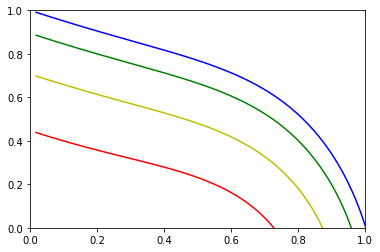

In [21]:
C0 = contour_avec_gradient(f, 0.2)
C1 = contour_avec_gradient(f, 0.5)
C2 = contour_avec_gradient(f, 0.8)
C3 = contour_avec_gradient(f, 1)
plt.plot(C0[0], C0[1], color='r')
plt.plot(C1[0], C1[1], color='y')
plt.plot(C2[0], C2[1], color='g')
plt.plot(C3[0], C3[1], color='b')
plt.axis([0, 1, 0, 1])
plt.show()

### Critique

$\rightarrow$ Cette méthode est très approximative car elle se contente d'une valeur pour le point suivant sans vérifier qu'il s'agit effectivement d'un point fixe. L'erreur effectuée à chaque itération n'est donc pas corrigée et se propage car sert de base à la prochaine itération.

$\rightarrow$ On remarque aussi que la ligne s'interrompt nécessairement sur un point critique (gradient nul), et il est impossible de continuer la ligne à moins de la compléter en partant d'une autre direction pour rejoindre le fragment interrompu.

# Méthode de la Jacobienne, ou Newton en dimension deux

### Principe

L'objectif reste le même, c'est-à-dire de trouver les couples $(x,y)$ tels que : 
$$f(x,y) - c =0$$

mais l'idée est de traduire une deuxième condition qui pèse sur cette résolution, soit de trouver des points distants de $\delta$ les uns des autres : si $(a, b)$ est le point de l'itération précédente, alors on cherche $(x,y)$ tels que :

$$(x-a)^2+(y-b)^2-\delta^2 = 0$$

Satisfaire ces deux conditions revient donc à chercher les zéros de la fonction $g$ allant de $\mathbb{R}^2$ dans $\mathbb{R}^2$ définie par :

$$g(x,y)=(f(x,y)-c, (x-a)^2+(y-b)^2-\delta^2 )=(g_1 (x,y),g_2(x,y))$$

On utilise pour cela la méthode de Newton dans le cadre de fonctions de deux variables à valeurs vectorielles, on fait donc intervenir les dérivées partielles pour l'approximation au premier ordre de la recherche de solution. Le processus itératif de la recherche du point $(x_{k+1},y_{k+1})$ comme meilleure approximation de la solution $(x,y)$ à partir du point $(x_{k},y_{k})$ s'écrit :

$$\begin{pmatrix} x_{k+1} \\ y_{k+1}\end{pmatrix} = \begin{pmatrix} x_{k} \\ y_{k}\end{pmatrix} - J(x_{k},y_{k})^{-1} \begin{pmatrix} g_1(x_{k},y_{k}) \\ g_2(x_{k},y_{k})\end{pmatrix}$$

Avec $J(x,y)$ la matrice jacobienne de $g$ évaluée en $(x,y)$, soit :
$$J(x,y) = \begin{pmatrix} \frac{\partial g_1}{\partial x}(x,y) & \frac{\partial g_1}{\partial y}(x,y) \\ \frac{\partial g_2}{\partial x}(x,y) & \frac{\partial g_2}{\partial y}(x,y) \end{pmatrix}$$

La calcul de la jacobienne donne la forme suivante qui sera utilisée dans le programme :
$$J(x,y) = \begin{pmatrix} \frac{\partial f}{\partial x}(x,y) & \frac{\partial f}{\partial y}(x,y) \\ 2x & 2y \end{pmatrix}$$

### Programmation

$\rightarrow$ On se place sur le bord du cadre pour initialiser la recherche et trouver une amorce $(a,b)$

$\rightarrow$ On calcule le gradient de la fonction en ce point $\overrightarrow{\nabla f}(a,b) = \begin{pmatrix} G_x \\ G_y\end{pmatrix}$

$\rightarrow$ On cherche un vecteur orthogonal au gradient en ce point, par exemple $\overrightarrow{V} = \begin{pmatrix} G_y \\ -G_x\end{pmatrix}$

$\rightarrow$ On normalise ce vecteur et on se déplace d'un vecteur $\overrightarrow{U}$ de norme $\delta$ tel que $\overrightarrow{U} = \delta \frac{\overrightarrow{V}}{||\overrightarrow{V}||}$ d'où les coordonnées $(x_0,y_0)$ du point suivant :
$$
\left \{
\begin{array}{r r}
      x_0  & = & a + U_x \\
      y_0  & = & b + U_y
\end{array}
\right  .
$$

$\rightarrow$ On démarre ensuite le processus itératif décrit dans le principe que l'on fait converger vers le prochain point de la ligne de niveau avec pour première valeur $(x_0,y_0)$:
$$\begin{pmatrix} x_{k+1} \\ y_{k+1}\end{pmatrix} = \begin{pmatrix} x_{k} \\ y_{k}\end{pmatrix} - J(x_{k},y_{k})^{-1} \begin{pmatrix} g_1(x_{k},y_{k}) \\ g_2(x_{k},y_{k})\end{pmatrix}$$

$\rightarrow$ Une fois satisfait de la solution obtenue, on stocke le point trouvé et ce dernier donne sa valeur à $(a,b)$ pour réitérer le procédé selon la première étape



### Programme

In [22]:
import matplotlib.pyplot as plt
import autograd
import math
from autograd import numpy as np

### Recherche de l'amorce

def find_seed(g, a=0, b=1, c=0, eps=2**-26) :
    """Approche par dichotomie un antecedent a c par la fonction continue g,
    en demarrant la dichotomie aux points a et b. S'arrete a une precision eps (longeur de l'intervalle de fluctuation).
    Leve une exception si la condition de base de la dichotomie n'est pas respectee."""
    
    if b<a : a,b = b,a
        
    if g(a)>g(b) :
        h = lambda x : c-g(x)
    else :
        h = lambda x : g(x)-c
    #on se ramene a une fonction "presque croissante" a annuler

    assert h(a)*h(b)<=0
    
    for i in range(20) : #si au bout de 20 tours on n'est toujours pas sous eps, on arrete quand même
        m = (b+a)/2
        if h(m)<0 : a = m
        else : b = m
        if b-a<eps : break
    
    return (b+a)/2


### Définition de la fonction f

def f(x, y):
    """Définit la fonction dont on veut déterminer les lignes de niveaux"""
    return x**2 + y**2 - x

### Calcul de la fonction gradient à partir de autograd

def gradient(f):
    """Renvoie les dérivées partielles de f fonction de deux variables"""
    g = autograd.grad
    return g(f, 0), g(f, 1)

### Définition du problème à deux conditions

def g(x, y, a, b, c, delta):
    """Définit la fonction g qui contient la condition de ligne de niveau et de distance entre chaque itération"""
    return np.array([f(x,y)-c, (x - a)**2 + (y - b)**2 - delta**2])

### Calcul du point servant de départ au prochain calcul
    
def point_suivant(f, a, b, delta):
    """Calcul le point de départ de la prochaine itération à partir du gradient"""
    v = np.array([gradient(f)[1](float(a), float(b)), -gradient(f)[0](float(a), float(b))])
    u = v/(math.sqrt(v[0]**2 + v[1]**2))
    x0 = a + delta*u[0]
    y0 = b + delta*u[1]
    return (x0, y0)

### Création de la jacobienne de g à partir du gradient de f

def jacob(f, x, y):
    """Calcul de la jacobienne de g à partir des dérivées partielles de f"""
    gf1 = gradient(f)[0](x,y)
    gf2 = gradient(f)[1](x,y)
    return np.array([[gf1, gf2], [2*x, 2*y]])

### Calcul d'un déterminant d'un matrice 2x2

def determinant(M) :
    """Renvoie le déterminant d'un matrice 2x2"""
    a, b, c, d = M[0][0], M[1][0], M[0][1], M[1][1]
    return a*d - b*c
    
### Calcul de l'inverse d'un matrice 2x2

def inverse(M):
    """Renvoie l'inverse d'un matrice 2x2 inversible"""
    a, b, c, d = M[0][0], M[1][0], M[0][1], M[1][1]
    try :
        return np.array([[d, -c],[-b, a]])/determinant(M)
    except :
        raise Exception("Matrice singulière")

### Calcul des points de la ligne de niveau

def contour_newton(f, c=0, delta=0.01, depart='gauche'):
    
    if depart=="gauche" :
        h = lambda y : f(0,y)
        a = 0
        try : b = find_seed(h,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="droite" :
        h = lambda y : f(1,y)
        a = 1
        try : b = find_seed(h,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="bas" :
        h = lambda x : f(x,0)
        b=0
        try : a = find_seed(h,c=c)
        except Exception as Exc:
            return [],[]
    elif depart=="haut" :
        b=1
        h = lambda x : f(x,1)
        try : a = find_seed(h,c=c)
        except Exception as Exc :
            return [],[]
    else : raise ValueError("depart doit etre haut, bas, droite ou gauche")
    
    epsilon = 10**(-10)
    x0, y0 = a, b
    x1, y1 = x0, y0
    X, Y = [], []
    
    while x1 >= 0 and x1 <= 1 and y1 >= 0 and y1 <= 1 :
        
        k = 0
        a, b = x1, y1
        
        X.append(x1)
        Y.append(y1)
        
        x0 = point_suivant(f, a, b, delta)[0]
        y0 = point_suivant(f, a, b, delta)[1]
        
        while abs(f(x1, y1)-c) > epsilon and k <= 30: # on s'arrête forcément au-delà de 30 itérations
            
            jac_g = jacob(f, x0, y0)
            invJ = inverse(jac_g)
            g1 = g(x0, y0, a, b, c, delta)[0]
            g2 = g(x0, y0, a, b, c, delta)[1]
            Z = np.array([x0, y0]) - np.array([g1*invJ[0][0] + g2*invJ[0][1], g1*invJ[1][0] + g2*invJ[1][1]])
            x1, y1 = Z[0], Z[1]
            k = k + 1
            
    return np.array(X), np.array(Y)

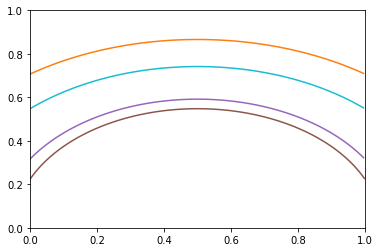

In [23]:
C0 = contour_newton(f, 0.05)
C1 = contour_newton(f, 0.1)
C2 = contour_newton(f, 0.3)
C3 = contour_newton(f, 0.5)
plt.plot(C0[0], C0[1], color='tab:brown')
plt.plot(C1[0], C1[1], color='tab:purple')
plt.plot(C2[0], C2[1], color='tab:cyan')
plt.plot(C3[0], C3[1], color='tab:orange')
plt.axis([0, 1, 0, 1])
plt.show()

### Critique

$\rightarrow$ Cette méthode est en fait l'amélioration de la méthode du gradient puisqu'elle prend chacun des points de la méthode précédente comme amorce pour converger vers un point fixe, elle est donc plus précise et propage moins d'erreurs.

$\rightarrow$ Là aussi, un gradient nul pose problème car il empêche de trouver un amorce au prochain calcul, et la méthode de Newton qui en découle pourrait converger vers le mauvais point de la ligne de niveau ou même rebrousser chemin.

$\rightarrow$ De plus, on calcule à chaque étape la jacobienne qui sera par la suite inversée, ce que l'on est pas garanti de pouvoir faire à chaque itération : cette méthode renvoie une erreur si la courbe de niveau n'est pas inversible localement sur un point du domaine concerné, ce qui est trés restrictif quant aux fonctions sur lesquelles on peut espérer travailler

$\rightarrow$ On remarque aussi que la recherche n'arrive pas à converger pour une valeur de $\delta$ trop faible, ce qui interdit une précision trop poussée

# Comparaison en temps

In [25]:
### Prenons par exemple cette fonction ni trop simple, ni trop compliquée

def f(x,y):
    return (x**2+y**2-x)*np.cos(x*y)

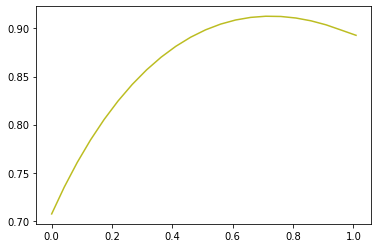

Wall time: 162 ms


In [30]:
%%time
A = simple_contour(f, 0.5)
plt.plot(A[0], A[1], color = 'tab:pink')
plt.show()

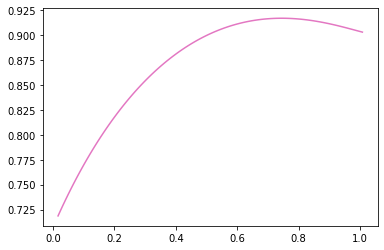

Wall time: 260 ms


In [31]:
%%time
B = contour_avec_gradient(f, 0.5)
plt.plot(B[0], B[1], color = 'tab:olive')
plt.show()

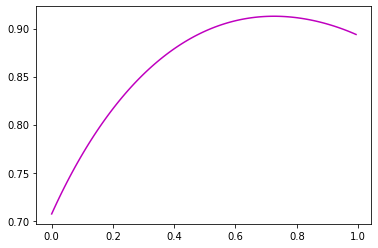

Wall time: 5.39 s


In [32]:
%%time
C = contour_newton(f, 0.5)
plt.plot(C[0], C[1], color = 'm')
plt.show()

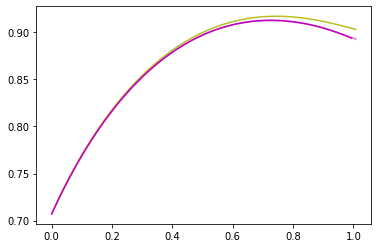

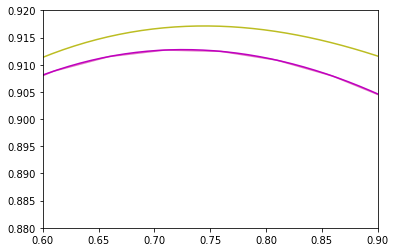

In [34]:
### Comparaison graphique des résultats

plt.plot(A[0], A[1], color = 'tab:pink') # méthode de dichotomie en rouge
plt.plot(B[0], B[1], color = 'tab:olive') # méthode du gradient
plt.plot(C[0], C[1], color = 'm') # méthode de Newton
plt.show()

### Zoom

plt.plot(A[0], A[1], color = 'tab:pink') # méthode de dichotomie en rouge
plt.plot(B[0], B[1], color = 'tab:olive') # méthode du gradient
plt.plot(C[0], C[1], color = 'm') # méthode de Newton
plt.axis([0.6,0.9,0.88,0.92])
plt.show()

### On remarque la propagation de l'erreur pour la méthode avec gradient

# Conclusion

$\rightarrow$ La méthode du gradient est rapide, imprécise et restrictive

$\rightarrow$ La méthode de Newton est lente, précise et restrictive

$\rightarrow$ La méthode de dichotomie est rapide, précise et quasiment non-restrictive

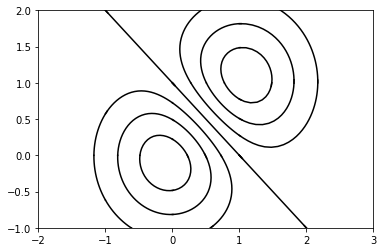

In [13]:
### Le produit final

def f(x,y) :
    return 2*(np.exp(-x*x-y*y)-np.exp(-(x-1)**2-(y-1)**2))

plt.axis([-2, 3, -1, 2])
C = [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

for c in C :
    X, Y = contour(f,c,xc=[-2,-1,0,1,3], yc=[-2,-1,0,1,2],ext=False)
    for XX, YY in zip(X,Y) :
        plt.plot(XX,YY,color="black")

plt.show()